# Dream: data analysis of simulated events
## Angular distribution of muons

Importing modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Loading data from `positions500.txt`:

In [5]:
# loading data from simulation
x,y,theta,phi = np.loadtxt("positions500.txt", unpack=True, usecols=(0,1,2,3))
directions = np.loadtxt("positions500.txt", unpack=True, usecols=(4,5,6))
positions = np.loadtxt("positions500.txt", unpack=True, usecols=(7,8,9))

# rescaling of units: mm >> cm
x = 0.1*x
y = 0.1*y

# number of Monte Carlo events
numberofevents = len(x)
print("You have {0} data".format(numberofevents))

You have 502 data


Theoretical distributions of randomic angles:
- Polar angle $\phi \in [0,2\pi]$:
$$p(\phi) = \frac{1}{2\pi}$$
- Azimuthal angle $\theta \in [0,\frac{\pi}{2}]$ (restriction):
$$p(\theta) = 3\cos(\theta)^2$$

In [6]:
# theoretical distribution functions of angles
def Ptheta(x):
    return 3*np.cos(x)*np.cos(x)

# generation of samples

sample_angles_theta = np.arange(0, 0.5*np.pi, 0.01)
sample_angulardistribution_theta = Ptheta(sample_angles_theta)

sample_angles_phi = np.arange(0, 2*np.pi, 0.01)
sample_angulardistribution_phi = [0.5/np.pi for i in np.arange(0, len(sample_angles_phi))]

Histograms of angles

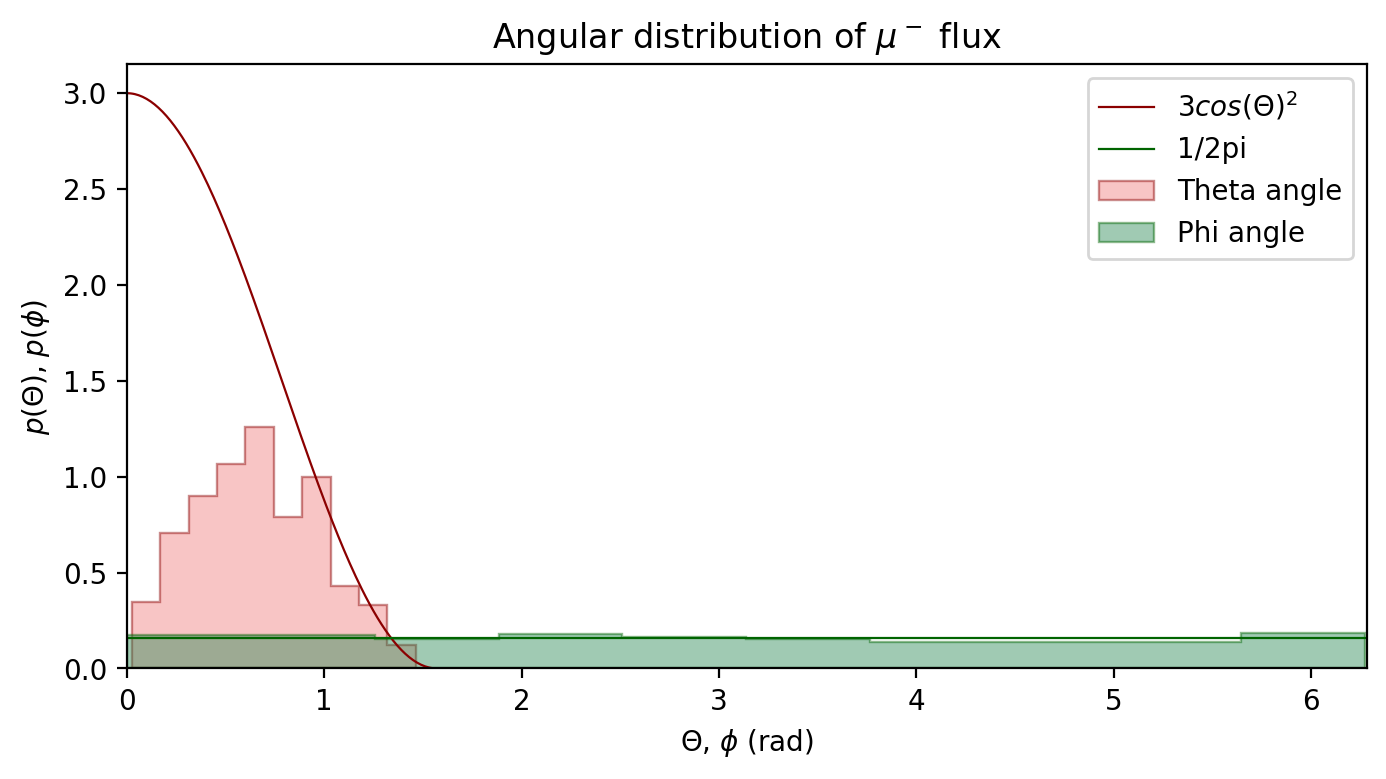

In [7]:
# prepare the figure
fig = plt.figure(111, figsize=(8,4), dpi=200)

#plot of histo & functions
plt.hist(theta, label='Theta angle', histtype="stepfilled",
         color="lightcoral", ec="darkred", alpha=0.45, lw=0.85, density=True)
plt.hist(phi, label='Phi angle', histtype='stepfilled',
         color="seagreen", ec="darkgreen", alpha=0.45,  lw=0.85, density=True)
plt.plot(sample_angles_theta, sample_angulardistribution_theta, label= '$3cos(\Theta)^2$', lw= 0.8 , color="darkred")
plt.plot(sample_angles_phi, sample_angulardistribution_phi, label= '1/2pi', lw= 0.8, color='darkgreen')

# features
plt.title('Angular distribution of $\mu^-$ flux')
plt.xlabel('$\Theta$, $\phi$ (rad)')
plt.ylabel('$p(\Theta)$, $p(\phi)$')
plt.xlim(0, 2*np.pi)
plt.legend()

plt.show()

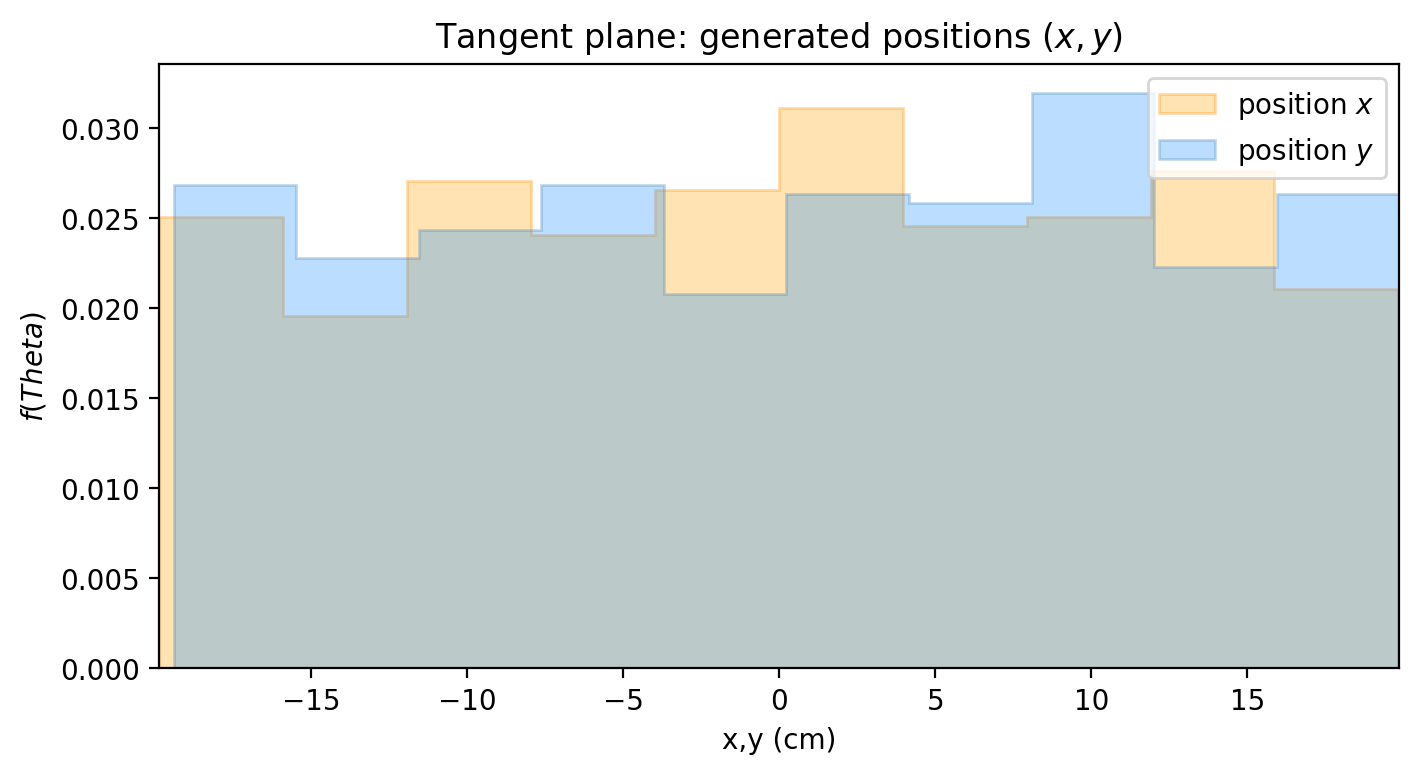

In [8]:
fig = plt.figure(111, figsize=(8,4), dpi=200)

plt.title('Tangent plane: generated positions $(x,y)$')
plt.xlabel('x,y (cm)')
plt.ylabel('$f(Theta)$')
plt.xlim(min(min(x),min(y)), max(max(x),max(y)))
plt.hist(x,lw=1, label='position $x$', histtype="stepfilled", color='orange', ec='darkorange', alpha=0.3, density=True)
plt.hist(y,lw=1, label='position $y$', histtype="stepfilled", color='dodgerblue', ec='steelblue', alpha=0.3, density=True)
plt.legend()
plt.show()